# Overview

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# !pip install yfinance

- We will get data from 1 year ago of XRP coin to now via the yfinance library.

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go


ticker = yf.Ticker("XRP-USD")
df = pd.DataFrame(ticker.history(period="5y", interval="1d").reset_index())
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df = df.asfreq('D')
ts = df['Open'].dropna()

backtest_ts = ts[:-365]
final_train_ts = ts[-365:]

print(df.head())
print(f"Tổng số ngày có dữ liệu: {len(df)}")

                               Open      High       Low     Close      Volume  \
Date                                                                            
2020-09-13 00:00:00+00:00  0.247814  0.253136  0.238857  0.241801  1163182194   
2020-09-14 00:00:00+00:00  0.241804  0.249822  0.240322  0.246327  1195994290   
2020-09-15 00:00:00+00:00  0.246265  0.249245  0.243392  0.243850  1245531094   
2020-09-16 00:00:00+00:00  0.244010  0.250974  0.236727  0.247847  1421286455   
2020-09-17 00:00:00+00:00  0.247743  0.258190  0.247218  0.252194  1735400721   

                           Dividends  Stock Splits  
Date                                                
2020-09-13 00:00:00+00:00        0.0           0.0  
2020-09-14 00:00:00+00:00        0.0           0.0  
2020-09-15 00:00:00+00:00        0.0           0.0  
2020-09-16 00:00:00+00:00        0.0           0.0  
2020-09-17 00:00:00+00:00        0.0           0.0  
Tổng số ngày có dữ liệu: 1827


<Axes: xlabel='Date'>

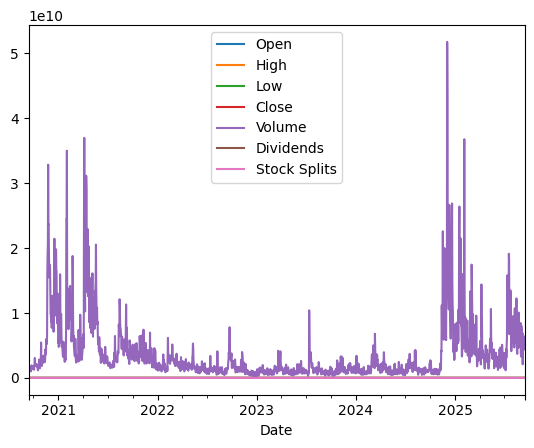

In [5]:
df.plot()

- To have an overview about data, we choose mean and standard deviation as 2 ratios to consider.

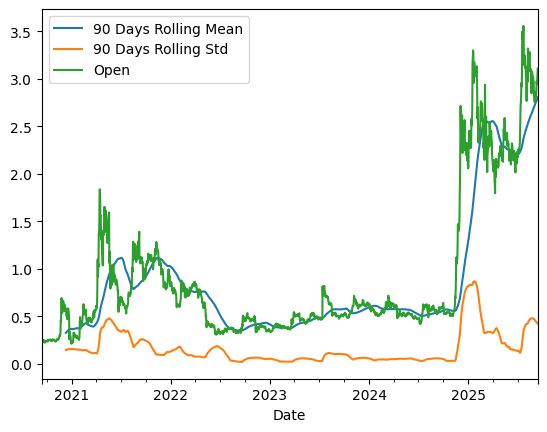

In [6]:
ts.rolling(90).mean().plot(label='90 Days Rolling Mean')
ts.rolling(90).std().plot(label='90 Days Rolling Std')
ts.plot()
plt.legend()

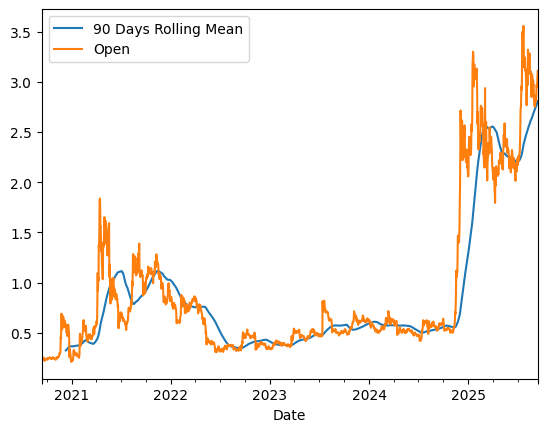

In [7]:
ts.rolling(90).mean().plot(label='90 Days Rolling Mean')
ts.plot()
plt.legend()

# ETS decomposition

- Decomposition gives us more valuable insights into the trends and patterns of the data, and also shows whether there is seasonality or not.

<Figure size 640x480 with 0 Axes>

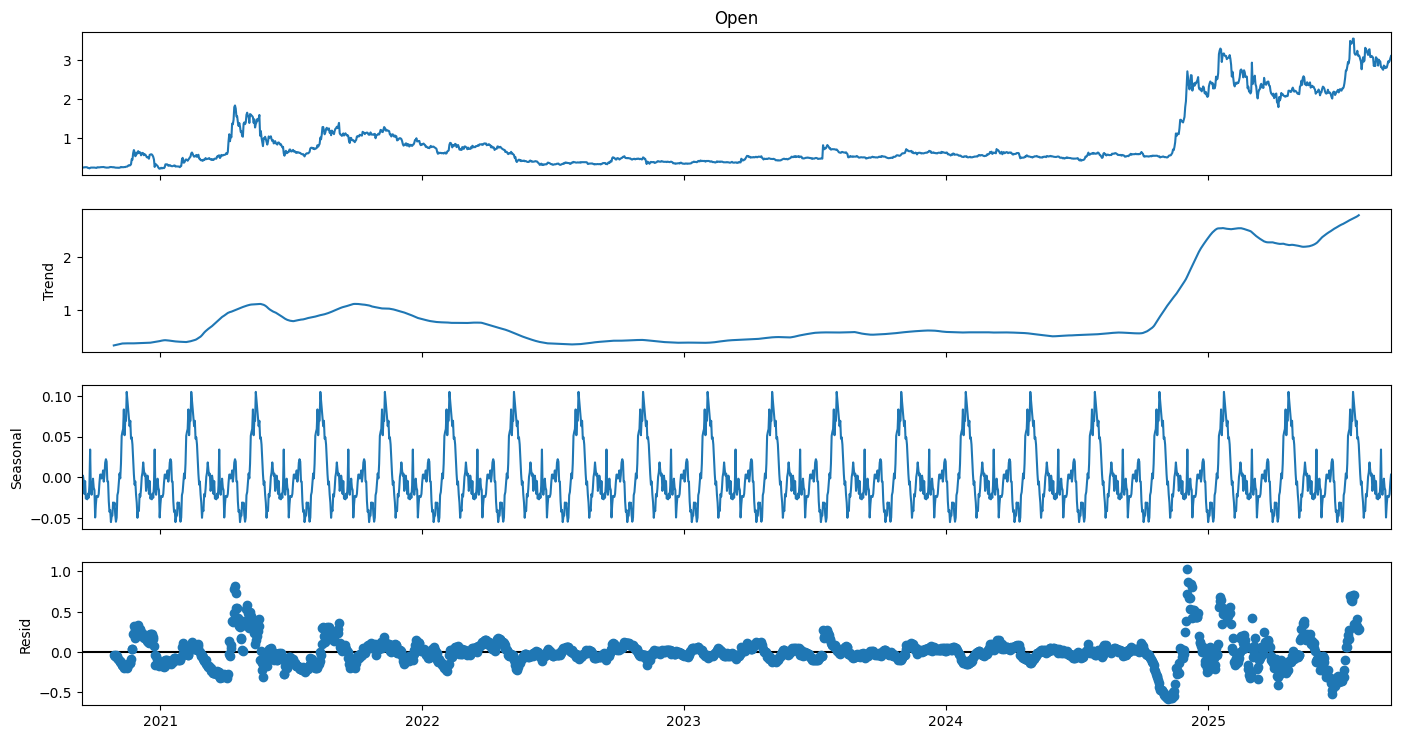

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, period=90) # 90 days
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

# Dicky Fuller test (also known as unit root test)

- Hypothesis:

  - Original hypothesis (H0): the series has unit root, i.e. non-stationary.

  - Alternative hypothesis (H1): the series is stationary.

In [9]:
# Store in a function for later use!
def adf_check(ts):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(ts)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [10]:
from statsmodels.tsa.stattools import adfuller
ts = df['Open'].dropna()
adf_check(ts)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.6969561217169391
p-value : 0.8475363963058912
#Lags Used : 21
Number of Observations Used : 1805
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


- Because p > 0.05, the time series is not stationary, we need to make it stationary through differentiation.

# Differencing.

- Now we will take the first difference to stop the series (If it hasn't stopped yet, continue taking the second, third,... differences until it stops).

## Before performing the differential

<Axes: xlabel='Date'>

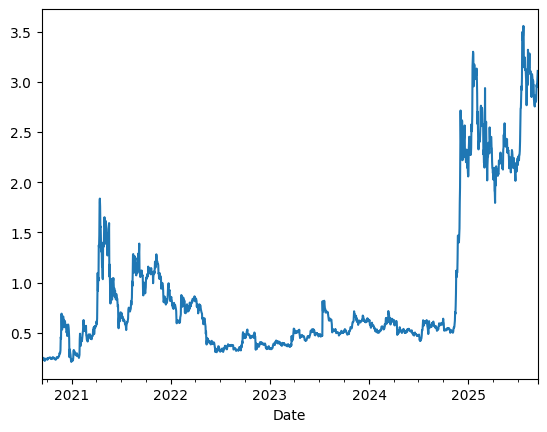

In [11]:
df['Open'].plot()

## After performing the differential

In [12]:
df['Open First Difference'] = df['Open'] - df['Open'].shift(1)
df['Open First Difference']

,Open First Difference
Date,
2020-09-13 00:00:00+00:00,NaN
2020-09-14 00:00:00+00:00,-0.006010
2020-09-15 00:00:00+00:00,0.004461
2020-09-16 00:00:00+00:00,-0.002255
2020-09-17 00:00:00+00:00,0.003733
...,...
2025-09-09 00:00:00+00:00,0.091847
2025-09-10 00:00:00+00:00,-0.023793
2025-09-11 00:00:00+00:00,0.035116


<Axes: xlabel='Date'>

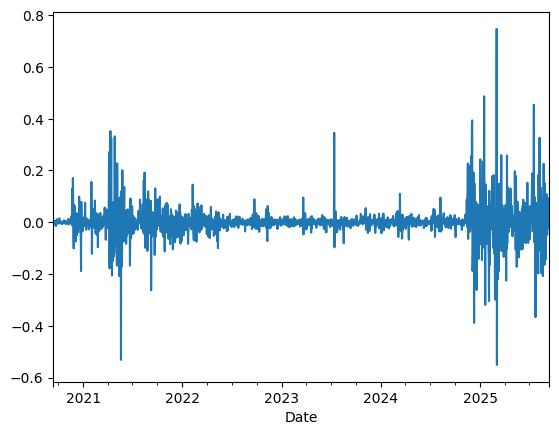

In [13]:
df['Open First Difference'].plot()

In [14]:
adf_check(df['Open First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -9.14131104888618
p-value : 2.844389716359841e-15
#Lags Used : 20
Number of Observations Used : 1805
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


- At this point, because p < 0.05, the series is stationary, suitable for inclusion in the ARIMA model or other time series analyses.
- Normally, after we perform the transformation (usually the first-order difference), the series will become stationary, suitable for entering the ARIMA model or other time series analysis.

# Autocorrelation and Partial Autocorrelation Plots

- We have found the coefficient d (number of differences) in the previous code, now to find the coefficients p and q for the ARIMA model we will go through ACF and PACF.

- What is autocorrelation?
  - The errors and noise of observations are correlated with the errors and noise of observations in the previous period when the order of observations cannot be changed.

- Lag:
  - Lag 1 (This period's data is noisy compared to the previous period immediately after it, for example this month compared to last month, this year compared to last year).
  - Lag 4 (Quarterly data) - This quarter compared to last quarter (often called seasonal lag).
  - Lag 12 (If we have monthly data, then the seasonal lag will be 12th lag).

In [15]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

### ACF

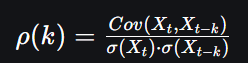

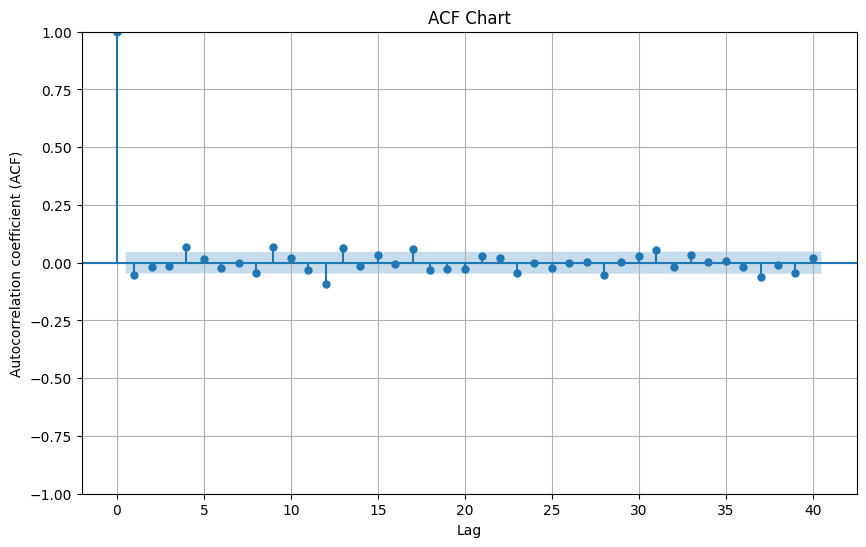

In [16]:
# Plot ACF chart
# Remember to exclude Null values
plt.figure(figsize=(10, 6))
fig_first = plot_acf(df['Open First Difference'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF Chart')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation coefficient (ACF)')
plt.grid(True)
plt.show()

- The first value (lag 0) is always 1, because a series is always perfectly correlated with itself.
- The correlation values ​​in the later lags (dots) show the correlation with the previous values, and they fall within the confidence interval (blue area), indicating that the series is stationary and there is no strong correlation between the values.

### PACF

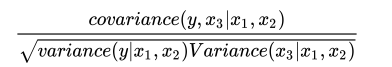

- The lag of order p is the value of the time step of the series backward.

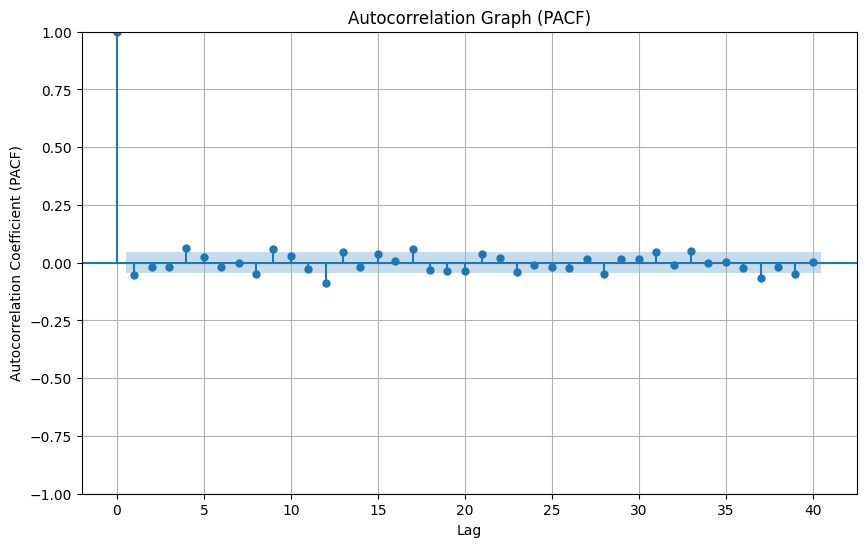

In [17]:
plt.figure(figsize=(10, 6))
fig_first = plot_pacf(df['Open First Difference'].dropna(), lags=40, ax=plt.gca())
plt.title('Autocorrelation Graph (PACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Coefficient (PACF)')
plt.grid(True)
plt.show()

- The confidence interval is the light blue area so if the data is within this area it is significant.

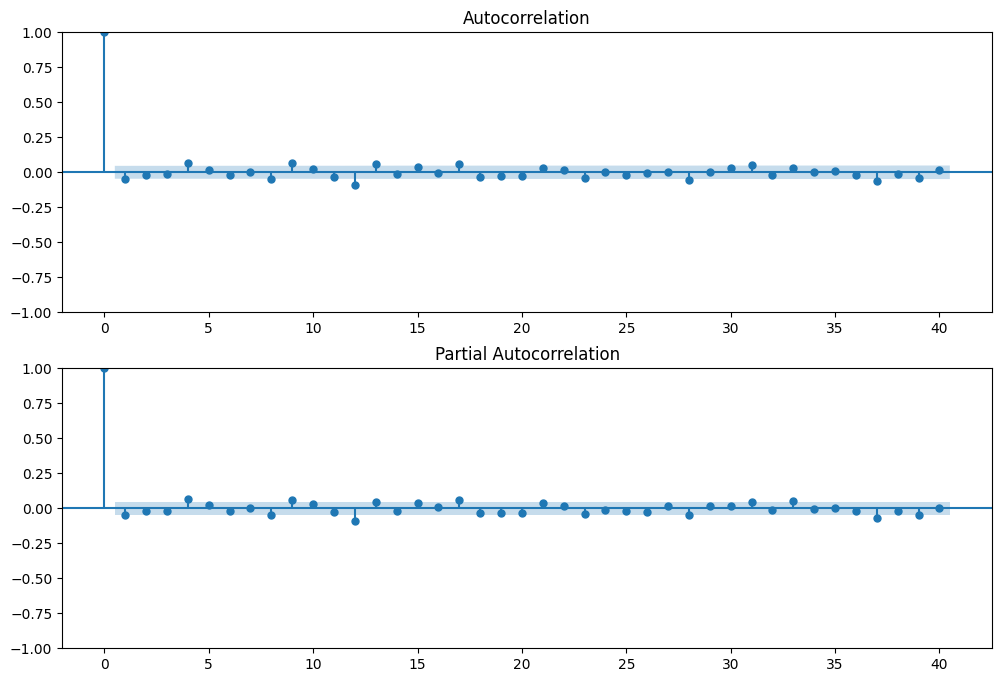

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Open First Difference'].dropna().iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Open First Difference'].dropna().iloc[13:], lags=40, ax=ax2)

# SARIMAX Model

- With the input parameter being 1 time difference and removing seasonality, the observation is within 90 days because our data is taken by day.

- Parameters Model Meaning:

  - p Auto-Regressive (AR): The model predicts the current value based on its own past values. p is the number of lagged values ​​of the time series that will be used as predictors.

  - d Integrated (I): The number of differencings required to make the time series stationary. A stationary time series is one whose mean and variance remain constant over time.

  - q Moving Average (MA): The model predicts the current value based on past prediction error values. q is the number of lagged prediction errors that will be used as predictors.

In [19]:
# seasonal_order will be in tuple form (p,d,q,S)
# S is the number of days of observation 90.
model = sm.tsa.statespace.SARIMAX(df['Open'],order=(0,1,0), seasonal_order=(0,1,0,90))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               Open   No. Observations:                 1827
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 90)   Log Likelihood                1823.404
Date:                            Sat, 13 Sep 2025   AIC                          -3644.808
Time:                                    10:45:36   BIC                          -3639.349
Sample:                                09-13-2020   HQIC                         -3642.789
                                     - 09-13-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0072   9.57e-05     74.893      0.000       0.007       0.007
Ljung-Box (L1) (Q):                

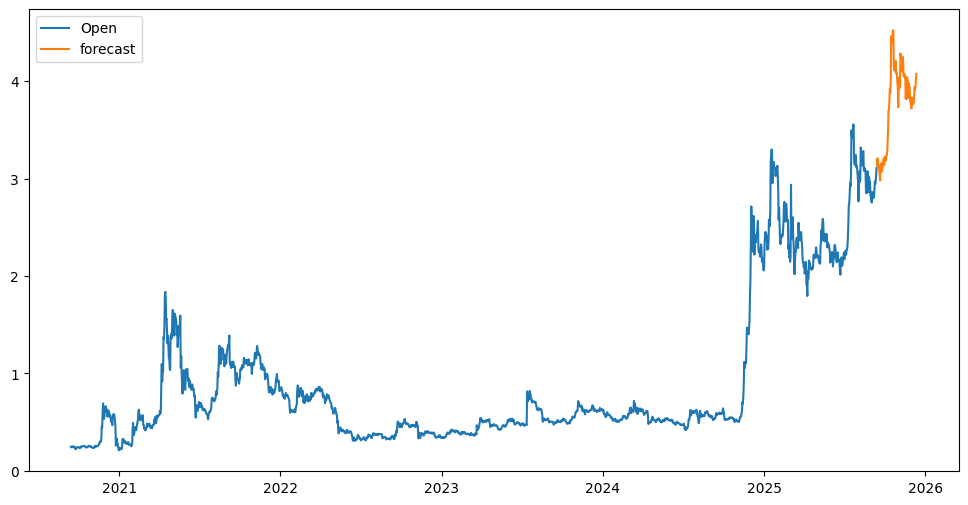

In [20]:
# Forecast for the desired period
# Forecast for the next 90 days
forecast = results.forecast(steps=90)

# Create a new date index for the forecast series
last_date = df.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=90, freq='D')
forecast.index = forecast_dates

plt.figure(figsize=(12,6))
plt.plot(df['Open'], label='Open')
plt.plot(forecast, label='forecast')
plt.legend()
plt.show()

# Backtest before putting into the model

In [21]:
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to evaluate the indexes
def evaluate_metrics(actual, forecast):
    """
    Calculate and print out the evaluation indexes: RMSE, MAE, MAPE, R^2.
    """

    valid_indices = ~np.isnan(actual) & ~np.isnan(forecast)
    actual = actual[valid_indices]
    forecast = forecast[valid_indices]

    rmse = np.sqrt(np.mean((actual - forecast)**2))
    mae = np.mean(np.abs(actual - forecast))
    # Avoid division by zero error
    mape = np.mean(np.abs((actual - forecast) / actual[actual != 0])) * 100
    r_squared = r2_score(actual, forecast)

    return rmse, mae, mape, r_squared, actual, forecast

In [22]:
def backtest_sarimax_revised(ts, order, seasonal_order, test_size_days, n_splits):
    """
    Perform a backtest of the SARIMAX model on time series, using older data to evaluate performance.
    """
    all_metrics = []
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(ts, label="Backtest Data (Train)", color='gray', alpha=0.6)

    split_points = [len(ts) - test_size_days * i for i in range(n_splits, 0, -1)]

    for i, split in enumerate(split_points):
        train = ts[:split]
        # Convert test to Pandas Series to get index
        test = ts.iloc[split:split + test_size_days]

        try:
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                            enforce_invertibility=False, enforce_stationarity=False)
            fitted = model.fit(disp=False)

            forecast = fitted.forecast(steps=len(test))
            forecast.index = test.index

            rmse, mae, mape, r_squared, actual, forecast = evaluate_metrics(test, forecast)
            all_metrics.append({
                'Split': i + 1,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape,
                'R^2': r_squared
            })

            print(f"Test times {i+1}: RMSE = {rmse:.3f}")
            print(f"Test times {i+1}: MAE = {mae:.3f}")
            print(f"Test times {i+1}: MAPE = {mape:.3f}")
            print(f"Test times {i+1}: R^2 = {r_squared:.3f}")

            ax.plot(test, label=f"Test {i+1}", color='blue', linewidth=2)
            ax.plot(forecast.index, forecast, label=f"Forecast {i+1}", color='red', linestyle='--', linewidth=2)

        except Exception as e:
            print(f"Error at the test {i+1}: {e}")

    ax.set_title("SARIMAX Backtest Results")
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()
    return all_metrics

Test times 1: RMSE = 0.130
Test times 1: MAE = 0.101
Test times 1: MAPE = 18.025
Test times 1: R^2 = -3.416
Test times 2: RMSE = 0.140
Test times 2: MAE = 0.112
Test times 2: MAPE = 20.491
Test times 2: R^2 = -7.295
Test times 3: RMSE = 0.063
Test times 3: MAE = 0.042
Test times 3: MAPE = 8.126
Test times 3: R^2 = -0.741
Test times 4: RMSE = 0.157
Test times 4: MAE = 0.137
Test times 4: MAPE = 24.171
Test times 4: R^2 = -6.761


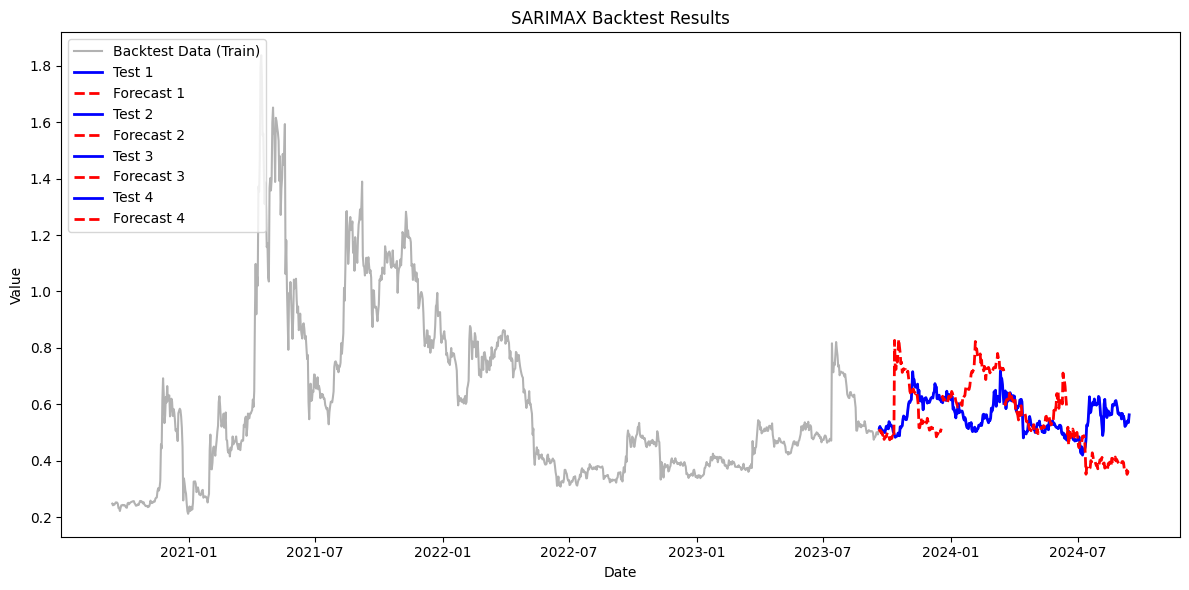

In [23]:
all_metrics = backtest_sarimax_revised(backtest_ts, order=(0,1,0), seasonal_order=(0,1,0,90), test_size_days=90, n_splits=4)

- Based on the metrics and graphs you provided, the SARIMAX model is performing very poorly. The metrics show that the model is not only predicting incorrectly, but is doing much worse than simply using the mean to predict.

- Analyzing the negative R^2 results: This is the most worrying metric. The more negative and larger the R^2 value (in absolute value), the worse your model is. A negative R^2 means that your model is worse than a "naive" model that just predicts the mean of the data.

- High MAPE: A mean absolute percentage error (MAPE) of 16% to over 37% is very high, indicating that the average prediction error of the model is very large compared to the actual value.

- High RMSE and MAE: RMSE and MAE are both error indices, and their high values ​​indicate that the error between the predicted value and the actual value is large.

- Causes and solutions:

  - Non-stationary data: Although you have taken the difference to get stationary data, the nature of the data may still be unstable.

  - Noisy data: The data has too much random noise, making it impossible for the model to find a pattern.

  - Inappropriate model: Based on the chart and indicators, your data seems to be very volatile and does not follow a clear trend or cycle that SARIMAX can model. Stock price data is often considered a random walk, which is difficult to predict with linear models like SARIMA.

  - Wrong parameters: The order and seasonal_order parameters you are using may not be the best choice. ConvergenceWarning is a clear sign of this. You should use automated tools to find the optimal parameters (e.g. auto_arima in Python's pmdarima library).

# GridCV Automatic Parameter Search Function

In [24]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

def grid_search_sarimax_params(ts, p_range, d_range, q_range, P_range, D_range, Q_range, s):
    """
    Find the optimal SARIMAX parameters using Grid Search.

    Parameters:
    ts: Pandas Series time series.
    p_range, d_range, q_range: Value ranges for non-seasonal parameters (p, d, q).
    P_range, D_range, Q_range: Value ranges for seasonal parameters (P, D, Q).
    s: Seasonal cycle.
    """
    print("----- Performing Grid Search for parameter SARIMAX -----")

    # Generate all parameter combinations
    pdq = list(itertools.product(p_range, d_range, q_range))
    seasonal_pdq = list(itertools.product(P_range, D_range, Q_range, [s]))

    best_aic = np.inf
    best_order = None
    best_seasonal_order = None

    # Disable convergence warnings to clean output
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', ConvergenceWarning)

        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    model = SARIMAX(ts,
                                    order=param,
                                    seasonal_order=param_seasonal,
                                    enforce_invertibility=False,
                                    enforce_stationarity=False)
                    results = model.fit(disp=False)

                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = param
                        best_seasonal_order = param_seasonal

                except Exception as e:
                    continue

    print("\n----- Optimal Result -----")
    print(f"Best SARIMAX with parameters: order={best_order}, seasonal_order={best_seasonal_order}")
    print(f"Corresponding AIC: {best_aic:.2f}")

    return best_order, best_seasonal_order

# Important step: Assign frequency to time series
# This helps to remove ValueWarning
ts = ts.asfreq('D')
#
p_range = range(0, 3)
d_range = range(0, 2)
q_range = range(0, 3)
P_range = range(0, 2)
D_range = range(0, 2)
Q_range = range(0, 2)
s = 30 # Chú ý chỗ này, nếu điền quá nhiều ngày (90 ngày) sẽ bị crash RAM

best_order, best_seasonal_order = grid_search_sarimax_params(
    ts,
    p_range=p_range,
    d_range=d_range,
    q_range=q_range,
    P_range=P_range,
    D_range=D_range,
    Q_range=Q_range,
    s=s
)
print(f"Best parameters: order={best_order}, seasonal_order={best_seasonal_order}")

----- Performing Grid Search for parameter SARIMAX -----

----- Optimal Result -----
Best SARIMAX with parameters: order=(2, 1, 2), seasonal_order=(0, 0, 0, 30)
Corresponding AIC: -4895.55
Best parameters: order=(2, 1, 2), seasonal_order=(0, 0, 0, 30)


- Based on the GRIDCV, we will select parameter for order (2, 1, 2) with seasonal_order (0, 0, 0, 30) to apply the model.

# Walk-forward Backtest

- This is the most advanced and realistic backtesting method. Instead of training the model once and forecasting for the entire 90 days, walk-forward forecasting will:

  - Train the model on past data.

  - Forecast for the next day.

  - Add the actual data of that day to the training set.

  - Retrain the model and repeat the process. This method simulates how you would use the model in the real world, where you would continuously update the model with new data.

- See if there is any improvement compared to the old backtest, is R^2 still negative?

In [25]:
def walk_forward_forecast(ts, order, seasonal_order, n_forecast_steps):
    """
    Perform step-by-step walk-forward forecasting and visualization.
    """
    history = ts.iloc[:-n_forecast_steps].copy()
    actual_values = ts.iloc[-n_forecast_steps:]

    predictions = list()
    all_metrics = []

    print("----- Performing Walk-Forward Forecasting -----")
    for i in range(n_forecast_steps):
        try:
            model = SARIMAX(history, order=order, seasonal_order=seasonal_order,
                             enforce_invertibility=False, enforce_stationarity=False)
            model_fit = model.fit(disp=False)

            output = model_fit.forecast(steps=1)
            yhat = output.iloc[0]

            obs = actual_values.iloc[i]
            predictions.append(yhat)
            history = pd.concat([history, pd.Series([obs], index=[actual_values.index[i]])])
            print(f"Date {actual_values.index[i].strftime('%Y-%m-%d')}: Forecast = {yhat:.4f}, Actual = {obs:.4f}")

        except Exception as e:
            print(f"Error at step {i+1}: {e}")

    predictions_series = pd.Series(predictions, index=actual_values.index)

    rmse, mae, mape, r_squared, actual, forecast = evaluate_metrics(actual_values, predictions_series)
    all_metrics.append({
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R^2': r_squared
    })

    print("\n----- Summary of Evaluation Results -----")
    for metric in all_metrics:
        print(f"RMSE: {metric['RMSE']:.4f}")
        print(f"MAE: {metric['MAE']:.4f}")
        print(f"MAPE: {metric['MAPE']:.4f}%")
        print(f"R^2: {metric['R^2']:.4f}")

    plt.figure(figsize=(15, 8))
    plt.plot(ts.index, ts.values, color='gray', label='Historical data')
    plt.plot(actual_values.index, actual_values.values, label='Actual values', color='blue', linewidth=2)
    plt.plot(predictions_series.index, predictions_series.values, label='Walk-Forward Forecasts', color='red', linestyle='--', linewidth=2)

    plt.title('Walk-Forward One-Step Forecast Results')
    plt.xlabel('Day')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    return actual_values, predictions_series

----- Performing Walk-Forward Forecasting -----
Date 2024-08-15: Forecast = 0.5736, Actual = 0.5692


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-08-16: Forecast = 0.5790, Actual = 0.5610


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-08-17: Forecast = 0.5600, Actual = 0.5645


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-08-18: Forecast = 0.5517, Actual = 0.5663


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-08-19: Forecast = 0.5919, Actual = 0.5639


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-08-20: Forecast = 0.5664, Actual = 0.5986


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-08-21: Forecast = 0.5865, Actual = 0.5944


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-08-22: Forecast = 0.5939, Actual = 0.6003


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-08-23: Forecast = 0.6078, Actual = 0.5976


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-08-24: Forecast = 0.6057, Actual = 0.6112


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-08-25: Forecast = 0.5973, Actual = 0.6131


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-08-26: Forecast = 0.6162, Actual = 0.6002


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-08-27: Forecast = 0.5961, Actual = 0.5875


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-08-28: Forecast = 0.5845, Actual = 0.5675


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-08-29: Forecast = 0.5642, Actual = 0.5698


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-08-30: Forecast = 0.5674, Actual = 0.5621


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-08-31: Forecast = 0.5625, Actual = 0.5670


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-09-01: Forecast = 0.5624, Actual = 0.5663


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-09-02: Forecast = 0.5726, Actual = 0.5480


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-09-03: Forecast = 0.5567, Actual = 0.5676


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-09-04: Forecast = 0.5668, Actual = 0.5574


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-09-05: Forecast = 0.5531, Actual = 0.5582


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Date 2024-09-06: Forecast = 0.5354, Actual = 0.5442


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-09-07: Forecast = 0.5377, Actual = 0.5213


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-09-08: Forecast = 0.5283, Actual = 0.5251


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-09-09: Forecast = 0.5239, Actual = 0.5293


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-09-10: Forecast = 0.5119, Actual = 0.5396


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-09-11: Forecast = 0.5479, Actual = 0.5411


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-09-12: Forecast = 0.5274, Actual = 0.5353


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Date 2024-09-13: Forecast = 0.5334, Actual = 0.5626

----- Summary of Evaluation Results -----
RMSE: 0.0148
MAE: 0.0121
MAPE: 2.1455%
R^2: 0.6399


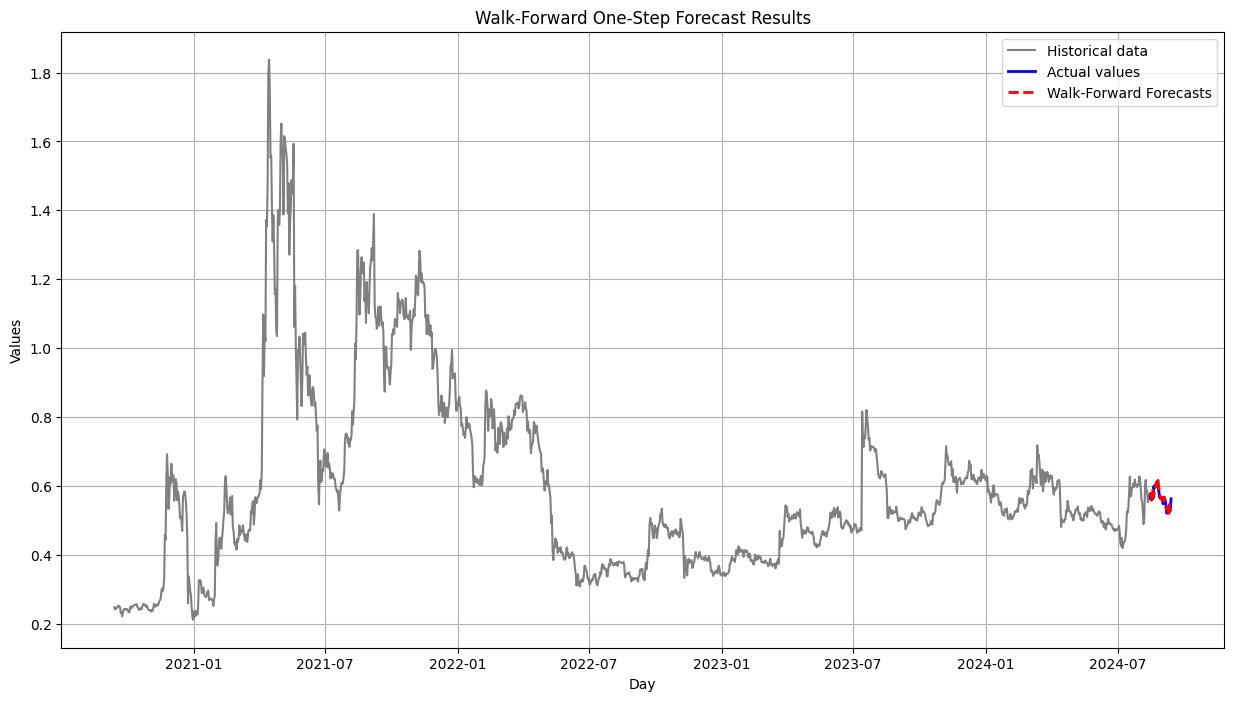

(np.float64(0.014793478399371505),
 np.float64(0.012145025145284554),
 np.float64(2.1455279873832778),
 0.639932953659555,
 Date
 2024-08-15 00:00:00+00:00    0.569191
 2024-08-16 00:00:00+00:00    0.560957
 2024-08-17 00:00:00+00:00    0.564514
 2024-08-18 00:00:00+00:00    0.566324
 2024-08-19 00:00:00+00:00    0.563874
 2024-08-20 00:00:00+00:00    0.598610
 2024-08-21 00:00:00+00:00    0.594427
 2024-08-22 00:00:00+00:00    0.600277
 2024-08-23 00:00:00+00:00    0.597600
 2024-08-24 00:00:00+00:00    0.611238
 2024-08-25 00:00:00+00:00    0.613110
 2024-08-26 00:00:00+00:00    0.600186
 2024-08-27 00:00:00+00:00    0.587454
 2024-08-28 00:00:00+00:00    0.567548
 2024-08-29 00:00:00+00:00    0.569849
 2024-08-30 00:00:00+00:00    0.562058
 2024-08-31 00:00:00+00:00    0.567026
 2024-09-01 00:00:00+00:00    0.566312
 2024-09-02 00:00:00+00:00    0.547986
 2024-09-03 00:00:00+00:00    0.567588
 2024-09-04 00:00:00+00:00    0.557398
 2024-09-05 00:00:00+00:00    0.558177
 2024-09-06 0

In [36]:
# Run the function and save the results into two variables
actuals_from_walkforward, predictions_from_walkforward = walk_forward_forecast(backtest_ts, order=(2,1,2), seasonal_order=(0,0,0,30), n_forecast_steps=30)
# Then call the evaluate function with the two variables just saved
evaluate_metrics(actuals_from_walkforward, predictions_from_walkforward)

- RMSE: 0.0148
- MAE: 0.0121
- MAPE: 2.1455%
- R^2: 0.6399

- Positive R^2 analysis: A big step forward! An R^2 of 0.6399 is a positive result. It shows that your model can explain about 63.99% of the variation in the data. Although not a very high number, it is much better than the previous negative R^2 values, indicating that your model has learned some rules from the data.

  - Low MAPE: The mean absolute percentage error (MAPE) of only 2.15% is a very good result. This means that on average, the model's prediction error is only about 2.15% of the actual value. For financial data, this is a very impressive number.

  - Small RMSE and MAE: The absolute error indices (RMSE and MAE) are also very small, indicating that the model's prediction error is very low.

- Why is Walk-Forward more effective?
  - This distinct difference comes from the nature of the walk-forward method:

    - Continuous retraining: The model is retrained after each forecast step by adding new real-world data to the training set. This allows the model to adapt quickly to the latest market changes and trends.

    - Short-term forecasting: The model only forecasts a single step (steps=1), which significantly reduces the error compared to forecasting a 90-day series at once.

    - Real-world simulation: This is how traders and analysts do forecasting in the real world, so the results of this method are often more reliable.

  - In short, switching to walk-forward testing helps you see the real performance of the model. The results show that the SARIMAX model, when trained and updated continuously, is capable of predicting small, short-term changes in financial markets, although it cannot predict large fluctuations in the distant future.

# Rerun SARIMAX

- Rerun the model after finding the optimal parameter set.

In [37]:
# Pass in data that is the closest year to the current date to train
model_sarimax = SARIMAX(ts, order=(2,1,2), seasonal_order=(0,0,0,30),
                        enforce_invertibility=False, enforce_stationarity=False)
results_sarimax = model_sarimax.fit(disp=False)

Next 90-day forecast:
2025-09-14 00:00:00+00:00    3.101001
2025-09-15 00:00:00+00:00    3.084833
2025-09-16 00:00:00+00:00    3.076287
2025-09-17 00:00:00+00:00    3.083890
2025-09-18 00:00:00+00:00    3.098916
                               ...   
2025-12-08 00:00:00+00:00    3.092367
2025-12-09 00:00:00+00:00    3.093140
2025-12-10 00:00:00+00:00    3.092036
2025-12-11 00:00:00+00:00    3.090298
2025-12-12 00:00:00+00:00    3.089769
Freq: D, Name: predicted_mean, Length: 90, dtype: float64


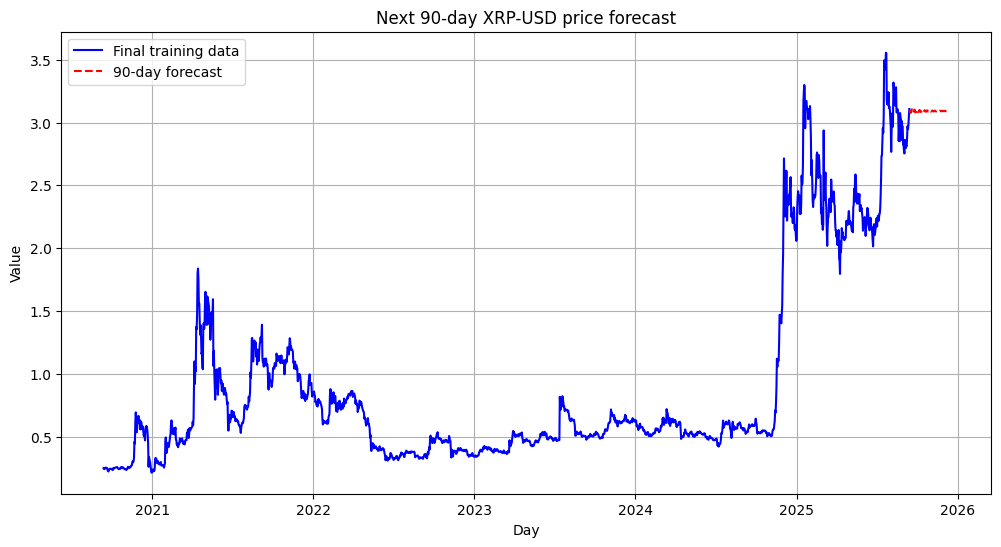

In [38]:
# Create a new date index for the forecast series
# Get the last date of the training data
last_date = ts.index[-1]
# Create a new date range starting from the day after the last date
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=90, freq='D')

# Get the forecast from the SARIMAX results
forecast_sarimax = results_sarimax.forecast(steps=90)

# Assign the new index to the forecast series
forecast_sarimax.index = forecast_dates
print("Next 90-day forecast:")
print(forecast_sarimax)

# Visualize the final forecast
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Final training data', color='blue')
plt.plot(forecast_sarimax.index, forecast_sarimax, label='90-day forecast', color='red', linestyle='--')
plt.title('Next 90-day XRP-USD price forecast')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# Find the highest value in the forecast data
max_price = forecast_sarimax.max()

# Find the date corresponding to that highest price
date_of_max = forecast_sarimax.idxmax()

# Print the result
print(f"The day with the highest price: {date_of_max.date()}")
print(f"The highest price: {max_price:.4f}")

The day with the highest price: 2025-09-19
The highest price: 3.1053


# ARIMA Model

- The purpose of training the final model is to make the most of all the historical information available. Although you used final_train_ts to find the optimal parameters, the final model used to forecast the future that has not yet happened will be more accurate when trained on a larger dataset.

- Increased accuracy: A model trained on 5 years of data will have a more comprehensive view of long-term trends, cycles, and major market events.

- Better forecasting: More data helps the model learn more rules, thereby making more reliable forecasts for the next 90 days.

In [30]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import itertools

def grid_search_arima_params(ts, p_range, d_range, q_range):
    """
    Perform Grid Search to find the optimal ARIMA(p, d, q) parameter.

    Parameters:
    ts: Pandas Series time series.
    p_range, d_range, q_range: Ranges of values ​​to search.
    """
    print("----- Performing Grid Search for ARIMA parameter -----")

    # Generate all parameter combinations
    pdq = list(itertools.product(p_range, d_range, q_range))
    best_aic = np.inf
    best_order = None

    for param in pdq:
        try:
            model = ARIMA(ts, order=param)
            results = model.fit()

            # Compare AIC to find the best model
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param

        except Exception as e:
            # Ignore invalid parameter combinations
            continue

    print("\n----- Optimal Result -----")
    print(f"Best ARIMA with parameter: order={best_order}")
    print(f"Corresponding AIC: {best_aic:.2f}")

    return best_order

In [31]:
grid_search_arima_params(ts, p_range=range(0, 3), d_range=range(0, 2), q_range=range(0, 3))

----- Performing Grid Search for ARIMA parameter -----


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



----- Optimal Result -----
Best ARIMA with parameter: order=(2, 1, 2)
Corresponding AIC: -4905.72


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2)

In [34]:
from statsmodels.tsa.arima.model import ARIMA

def final_arima_forecast_and_analysis(ts, steps=90):
    """
    Train the final ARIMA model, forecast 90 days, and analyze the results.

    Parameters:
    ts: Pandas Series time series with all data.
    steps: Number of days to forecast.
    """
    # Step 1: Train ARIMA model on all data
    print("----- Training ARIMA model on all data -----")
    model = ARIMA(ts, order=(2, 1, 2))
    results = model.fit()

    # Step 2: Forecast next 90 days
    print("----- Forecast next 90 days -----")
    forecast = results.forecast(steps=steps)
    # print(forecast)

    # Create date index for forecast series
    last_date = ts.index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.DateOffset(days=1),
    periods=steps, freq='D')
    forecast.index = forecast_dates

    # Step 3: Visualization
    plt.figure(figsize=(8, 6))

    # Plot historical data
    plt.plot(ts.index, ts.values, label='Historical Data', color='blue')

    # Plot forecast series
    plt.plot(forecast.index, forecast.values, label='90-Day Forecast', color='red', linestyle='--')

    # Set title and label
    plt.title('XRP-USD Price Forecast for the Next 90 Days (ARIMA)')
    plt.xlabel('Days')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast

----- Training ARIMA model on all data -----


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


----- Forecast next 90 days -----


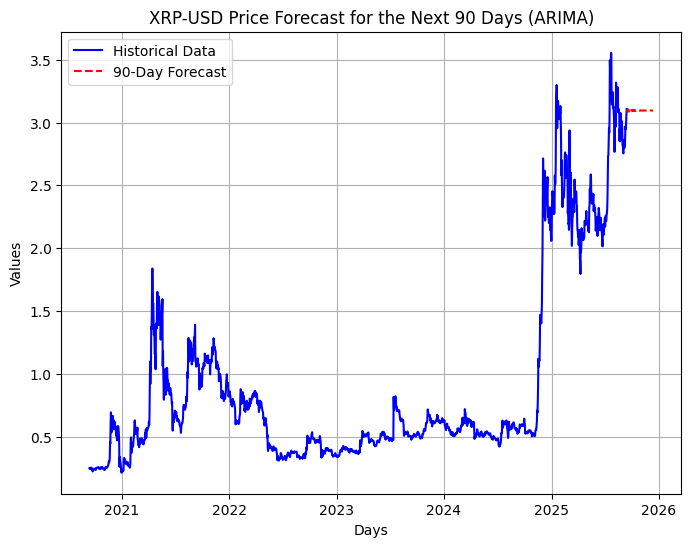

2025-09-14 00:00:00+00:00    3.102717
2025-09-15 00:00:00+00:00    3.090967
2025-09-16 00:00:00+00:00    3.085002
2025-09-17 00:00:00+00:00    3.090374
2025-09-18 00:00:00+00:00    3.100415
                               ...   
2025-12-08 00:00:00+00:00    3.095557
2025-12-09 00:00:00+00:00    3.095529
2025-12-10 00:00:00+00:00    3.095411
2025-12-11 00:00:00+00:00    3.095333
2025-12-12 00:00:00+00:00    3.095372
Freq: D, Name: predicted_mean, Length: 90, dtype: float64


In [35]:
forecast_90_days = final_arima_forecast_and_analysis(ts)
print(forecast_90_days)

In [40]:
# Find the highest value in the forecast data
max_price = forecast_90_days.max()

# Find the day corresponding to that highest price
date_of_max = forecast_90_days.idxmax()

# Print the result
print(f"The day with the highest price: {date_of_max.date()}")
print(f"The highest price: {max_price:.4f}")

The day with the highest price: 2025-09-19
The highest price: 3.1043
